# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Demo-of-pyGOpCO2" data-toc-modified-id="Demo-of-pyGOpCO2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Demo of pyGOpCO2</a></div><div class="lev2 toc-item"><a href="#Info" data-toc-modified-id="Info-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Info</a></div><div class="lev2 toc-item"><a href="#Usage" data-toc-modified-id="Usage-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Usage</a></div><div class="lev1 toc-item"><a href="#Level-1-processing" data-toc-modified-id="Level-1-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Level 1 processing</a></div><div class="lev2 toc-item"><a href="#Concatenate-raw-files" data-toc-modified-id="Concatenate-raw-files-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Concatenate raw files</a></div><div class="lev2 toc-item"><a href="#Check-value-ranges-as-a-first-pass" data-toc-modified-id="Check-value-ranges-as-a-first-pass-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Check value ranges as a first pass</a></div><div class="lev3 toc-item"><a href="#Faulty-variable-(string-in-float-array)" data-toc-modified-id="Faulty-variable-(string-in-float-array)-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Faulty variable (string in float array)</a></div><div class="lev2 toc-item"><a href="#Invalid-range" data-toc-modified-id="Invalid-range-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Invalid range</a></div><div class="lev1 toc-item"><a href="#Level-2-processing" data-toc-modified-id="Level-2-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Level 2 processing</a></div><div class="lev2 toc-item"><a href="#xCO2-to-fCO2" data-toc-modified-id="xCO2-to-fCO2-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>$x$CO2 to $f$CO2</a></div><div class="lev2 toc-item"><a href="#Diagnostic-plots" data-toc-modified-id="Diagnostic-plots-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Diagnostic plots</a></div><div class="lev2 toc-item"><a href="#WOCE-flagging" data-toc-modified-id="WOCE-flagging-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>WOCE flagging</a></div><div class="lev1 toc-item"><a href="#SOCAT-flags" data-toc-modified-id="SOCAT-flags-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SOCAT flags</a></div>

# Demo of pyGOpCO2

## Info

This is software to do the reduction of xCO2 to pCO2/fCO2 measured with the General Oceanics Underway pCO2 instrument.  
This demo shows an example of how to use the package. It is designed to be used in the Jupyter Notebook environment and is thus remarkably flexible and quick to use. 


## Usage

1. Concatenate the files
2. Check the ranges of the data as a preliminary check
3. Correct any data that is incorrect or missing (e.g. Latitude and Longitudes)
4. Convert xCO2 to fCO2
5. Plot diagnostic plots 
6. Run the automatic WOCE flags

In [6]:
%pylab inline

import __init__ as goCO2

rcParams['figure.dpi'] = 120

Populating the interactive namespace from numpy and matplotlib


# Level 1 processing
## Concatenate raw files

In [9]:
df1 = goCO2.lvl1.concat_co2_files('../Level_0/2015_WinterCruise/')


1. IMPORTING DATA
1.1 - Reading 38 files from ../Level_0/2015_WinterCruise/


## Check value ranges as a first pass

On the first run there seems to be something wrong and the script won't run. 
You can set the debug mode to `True` to see which variable trips the script up. 
You can then alter the level0_to_level1.expected_ranges dictionary so that the script will run (as shown in the following cell).

### Faulty variable (string in float array)

In [10]:
goCO2.lvl1.sanity_checker(df1, debug=True)

CO2x
Lat


TypeError: '>' not supported between instances of 'str' and 'int'

In [11]:
goCO2.lvl1.expected_ranges.pop('Lat', None)
goCO2.lvl1.expected_ranges.pop('Lon', None)
goCO2.lvl1.sanity_checker(df1)

1.2 - Sanity check: points within ranges
|------------------|--------------|---------|
|       NAME       |    RANGE     |   PCT   |
|------------------|--------------|---------|
| CO2x             |     0 : 4000 |    99.46|
|*Pres_atm_hpa     |   800 : 1200 |     0.00|
| Temp_intake      | -   2 :   35 |    99.80|
| Salt_tsg         |    25 :   38 |    96.51|
| Pres_equ_hpa     | -  10 :   10 |    99.77|
| Temp_equ         | -   2 :   35 |    99.93|
| Pres_licor_hpa   |   800 : 1200 |    99.93|

 *Salt_tsg doesnt have to be in range for script to work


## Invalid range
We now see that there is something wrong withd the Atmospheric pressure - none of the points are within the expected range of 800 to 1200 hPa. We plot the variable below to see what the issue is.

Here we see that the Atmospheric pressure sensor is returning hPa/1000. This is easily fixed by * 1000. There are also many `NaN` values. We can linearly interplate these to fill the gaps

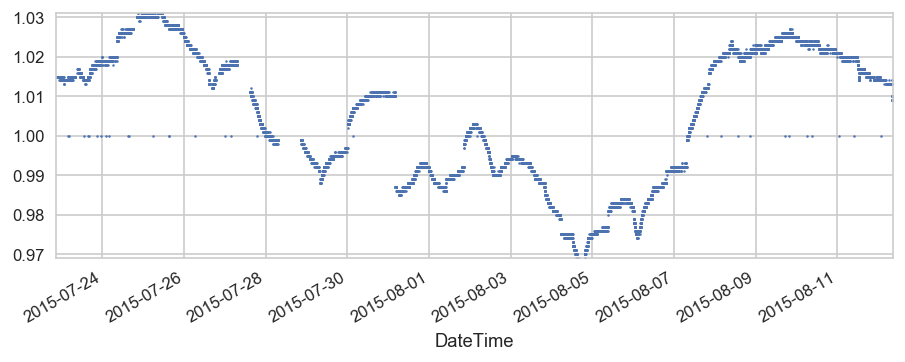

In [12]:
quantile = df1.Pres_atm_hpa.quantile([0.01, 0.99])
df1.Pres_atm_hpa.plot(ylim=quantile, figsize=[9, 3], marker='.', lw=0, ms=3)
show()

In [13]:
df1.loc[:, 'Pres_atm_hpa'] *= 1000. if df1.Pres_atm_hpa.mean() < 500 else 1.
df1.loc[:, 'Pres_atm_hpa'] = df1.Pres_atm_hpa.interpolate(method='linear', limit=240)

goCO2.lvl1.sanity_checker(df1)

1.2 - Sanity check: points within ranges
|------------------|--------------|---------|
|       NAME       |    RANGE     |   PCT   |
|------------------|--------------|---------|
| CO2x             |     0 : 4000 |    99.46|
| Pres_atm_hpa     |   800 : 1200 |    99.97|
| Temp_intake      | -   2 :   35 |    99.80|
| Salt_tsg         |    25 :   38 |    96.51|
| Pres_equ_hpa     | -  10 :   10 |    99.77|
| Temp_equ         | -   2 :   35 |    99.93|
| Pres_licor_hpa   |   800 : 1200 |    99.93|

 *Salt_tsg doesnt have to be in range for script to work


# Level 2 processing

## $x$CO2 to $f$CO2

This step performs all the calculations required to estimate fCO2 and pCO2. This is done in the script. 

In [14]:
df2 = goCO2.lvl2.xCO2_to_fCO2(df1)



2. CONVERTING xCO2 TO fCO2:
2.0 - Filling missing or 0 Salt_tsg values to 34.50
2.1 - Calibration factor from standards
2.2 - Water vapour factor from temp and salt
2.4 - Correcting for non-ideal behaviour of CO2
2.3 - Temperature correction factor
2.2 - Water vapour factor from temp and salt
2.4 - Correcting for non-ideal behaviour of CO2


/Users/luke/Dropbox/SOCCO_data/GOpCO2/pyGOpCO2/level1_to_level2.py:280: RuntimeWarning: overflow encountered in exp
  temp_correct_factor = np.exp(0.0423 * delta_temp)
/Users/luke/Dropbox/SOCCO_data/GOpCO2/pyGOpCO2/level1_to_level2.py:302: RuntimeWarning: overflow encountered in exp
  ideal_gas_corr = np.exp(Pa * (bT + 2 * (1 - xCO2)**2 * vca) / (R * Tk))


## Diagnostic plots

The purpose of the diagnostic plots is to help apply flags to the data. The defaults for these flags are from the SOCAT recommended limits. These are applied to the data. Note that Latitude and Longitude are not assessed in the flagging. It is up to the user to figure this out. 


Note that `level1_to_level2.xCO2_to_fCO2` returns a dataframe that recognises the measurement Type.  
For example you can plot all equilibrator xCO2 with:  
`df.EQU.xCO2.plot()`

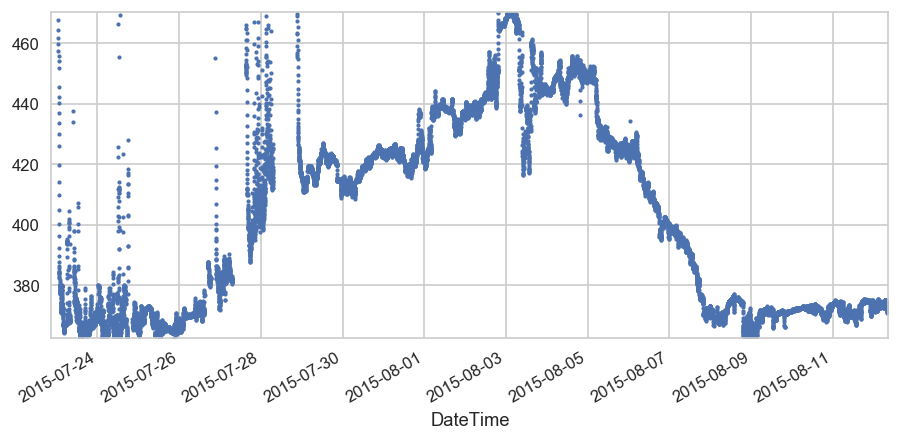

In [15]:
lims = df2.EQU.CO2x_cor.quantile([0.01, 0.99])
df2.EQU.CO2x_cor.plot(marker='.', ms=5, lw=0, figsize=[9, 4], ylim=lims)

/Users/luke/Development/miniConda/lib/python3.6/site-packages/numpy/ma/core.py:2163: RuntimeWarning: invalid value encountered in less
  condition = (xf < v1) | (xf > v2)
/Users/luke/Development/miniConda/lib/python3.6/site-packages/numpy/ma/core.py:2163: RuntimeWarning: invalid value encountered in greater
  condition = (xf < v1) | (xf > v2)
/Users/luke/Dropbox/SOCCO_data/GOpCO2/pyGOpCO2/diagnostic_plots.py:89: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  props = dict(facecolor=ax[i].get_axis_bgcolor(),


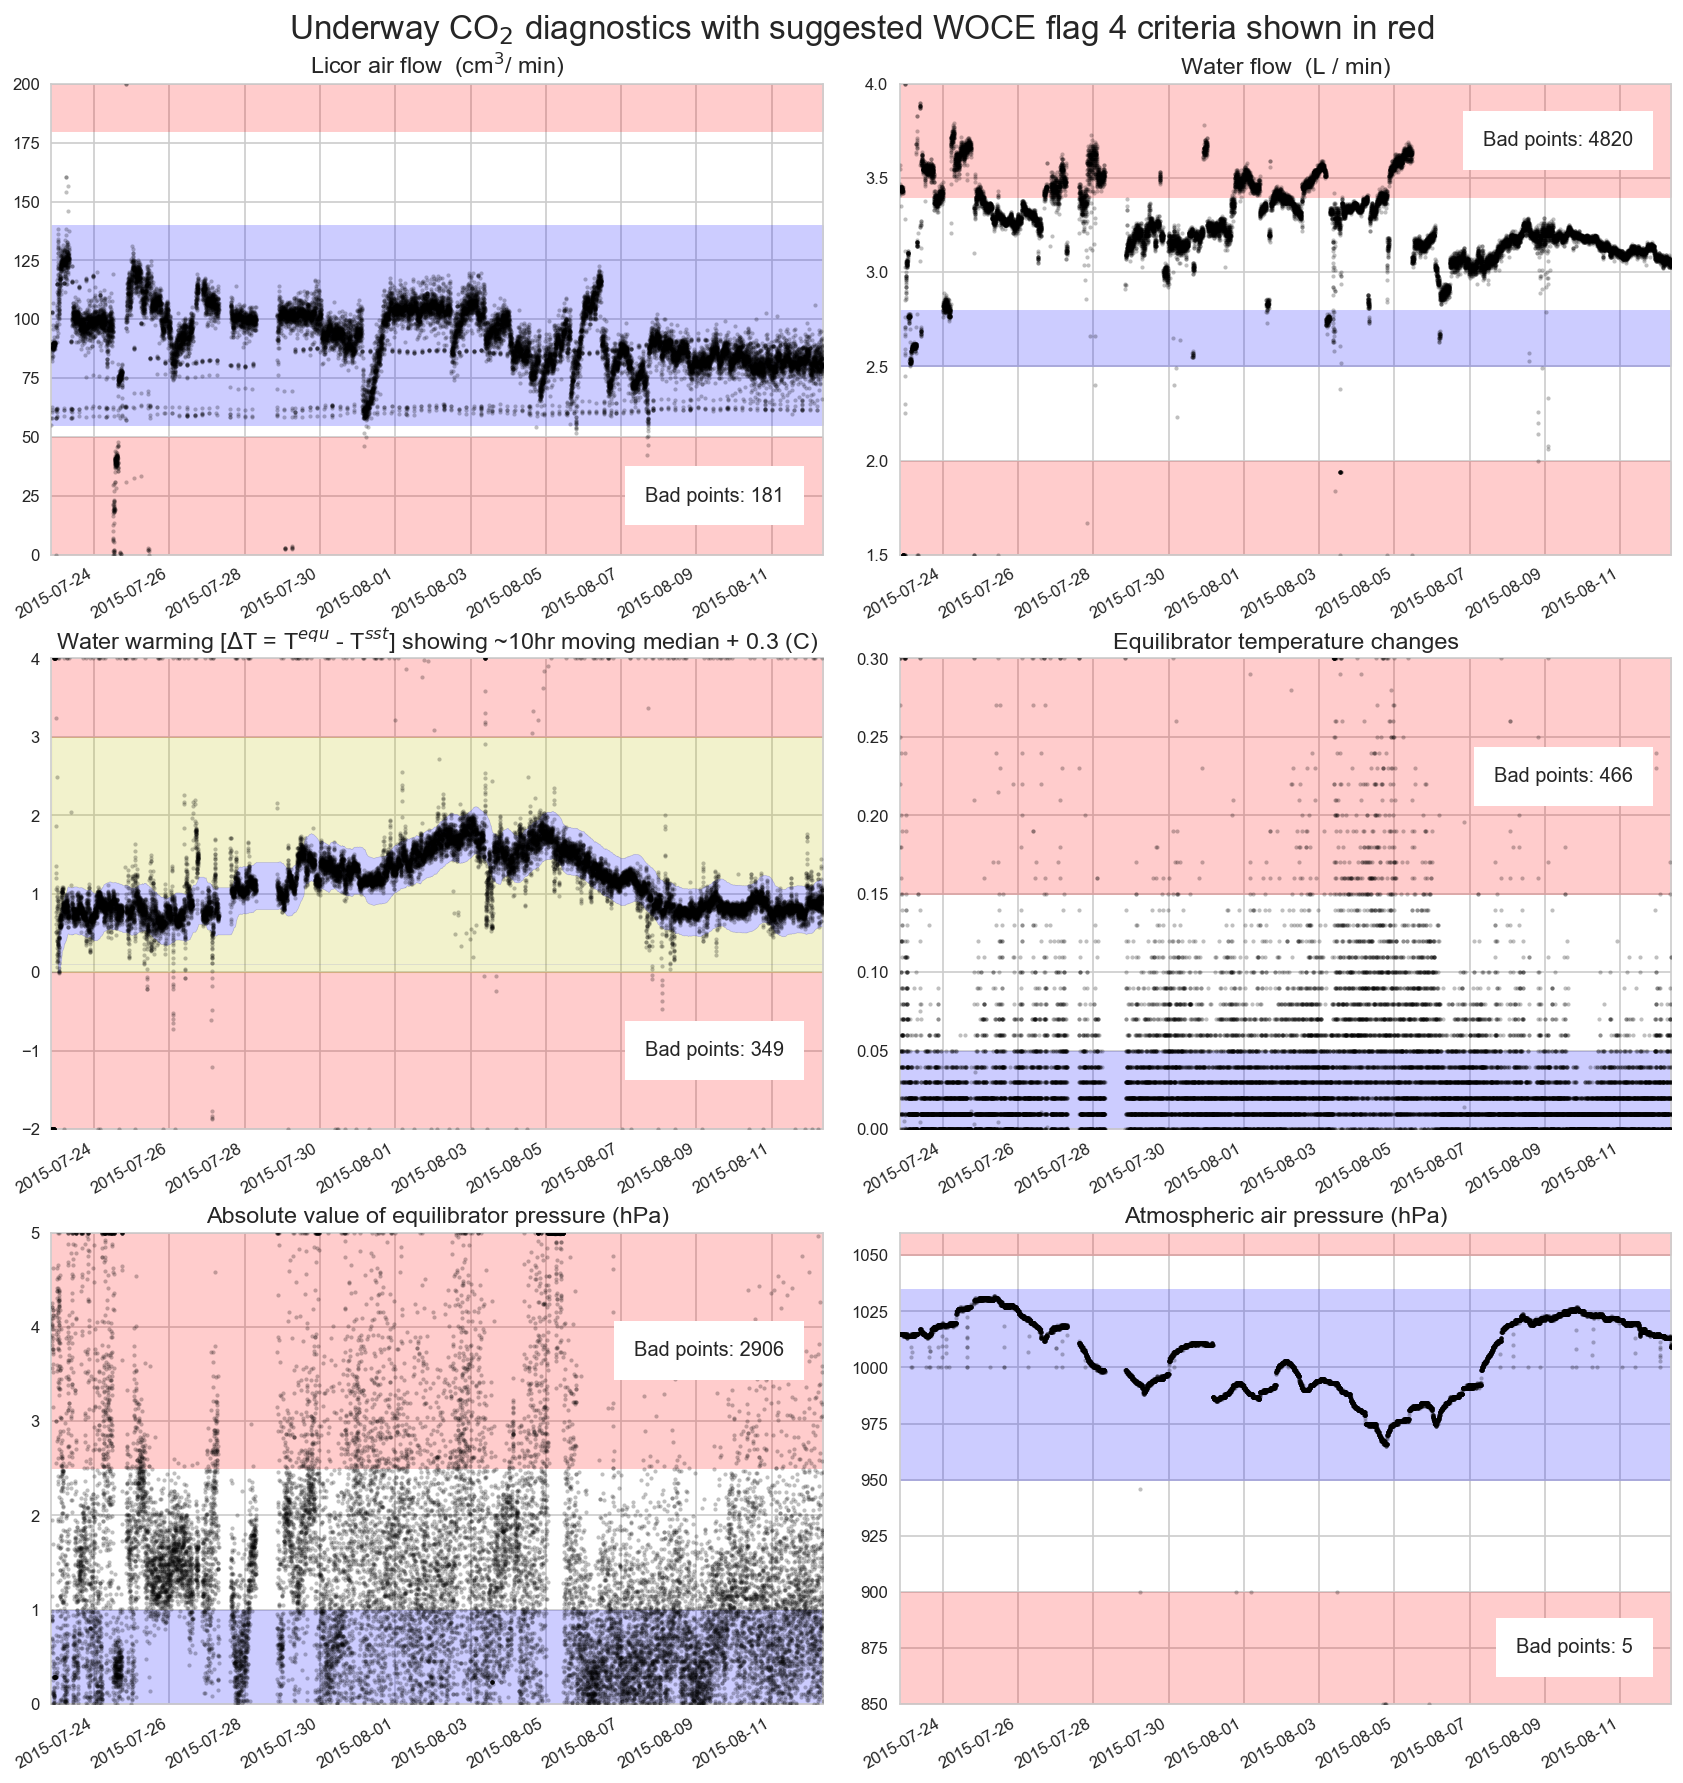

In [16]:
fig = goCO2.dp.plot_qaulity_control(df2)
show()

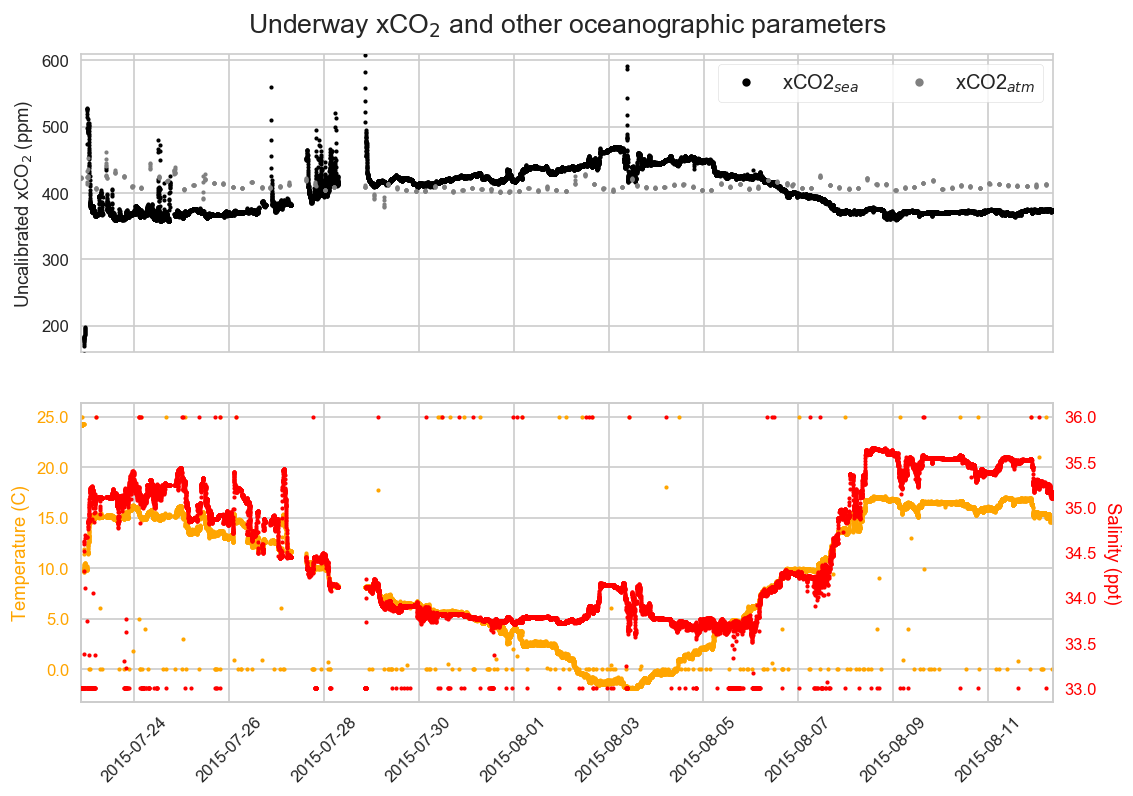

In [18]:
fig = goCO2.dp.plot_ocean_params(df2)
show()

## WOCE flagging

All the default limits are shown in the dictionary below. These can be changed by the user as shown in the following cell.

There are a few syntax tricks in the flag dictionary. The @ symbol shows to apply one of three commands:

- `abs` which is the absolute value
- `abs.diff` which is the absolute difference between adjacent points 
- `outlier` which uses a 240 measurement rolling median with a window around it to find outliers. 

In [19]:
goCO2.lvl2.flag4

{'CO2x': [-10, 600],
 'CO2x@abs.diff': [0.0, 10],
 'Pres_atm_hpa': [900, 1100],
 'Pres_equ_hpa@abs': [0, 10],
 'Salt_tsg': [5.0, 40],
 'Temp_equ': [-2.0, 32],
 'Temp_equ@abs.diff': [0.0, 0.15],
 'Temp_intake': [-2.0, 32],
 'Temp_intake@abs.diff': [0.0, 0.5],
 'Temp_warming': [0.0, 3.0],
 'Temp_warming@outlier': [0.0, 0.3],
 'flow_h2o_Lmin': [2.0, 3.2],
 'flow_licor_cm3min': [40.0, 150]}

In [20]:
goCO2.lvl2.flag4.update({
    'Salt_tsg': [33.5, 35.9],  # specific to this cruise based on plots above
    'Temp_intake': [-2, 20],
    'flow_h2o_Lmin': [2, 4],  # values aren't too drastic - give some leeway
    'CO2f_atm@abs.diff': [0, 2],
    'CO2f_sst@abs.diff': [0, 2],
    'CO2x': [0, 1000],
})

df2 = goCO2.lvl2.quality_control_flags(df2)
df3 = df2.loc[df2.Flag_CO2f_WOCE == 2, :]



3. QUALITY CONTROL
|--------------------------|-------------------|---------------|
|           KEYS           |       LIMIT       |    FLAGGED    |
|--------------------------|-------------------|---------------|
| CO2x                     |    0.00 : 1000.00 |   121 / 20651 |
| CO2x@abs.diff            |    0.00 :   10.00 |   911 / 20651 |
| flow_h2o_Lmin            |    2.00 :    4.00 |    67 / 20651 |
| flow_licor_cm3min        |   40.00 :  150.00 |   142 / 20651 |
| Pres_atm_hpa             |  900.00 : 1100.00 |     7 / 20651 |
| Pres_equ_hpa@abs         |    0.00 :   10.00 |    48 / 20651 |
| Temp_equ                 | -  2.00 :   32.00 |    14 / 20651 |
| Temp_intake              | -  2.00 :   20.00 |   125 / 20651 |
| Temp_equ@abs.diff        |    0.00 :    0.15 |   468 / 20651 |
| Temp_intake@abs.diff     |    0.00 :    0.50 |   434 / 20651 |
| Temp_warming             |    0.00 :    3.00 |   364 / 20651 |
| Temp_warming@outlier     |    0.00 :    0.30 |  1665 / 20651 |
| Sa

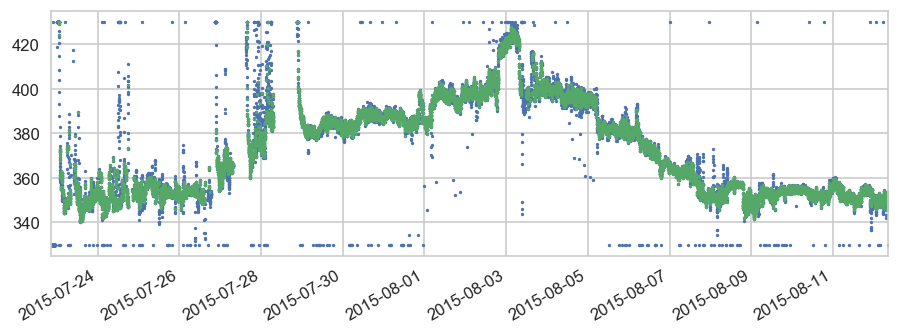

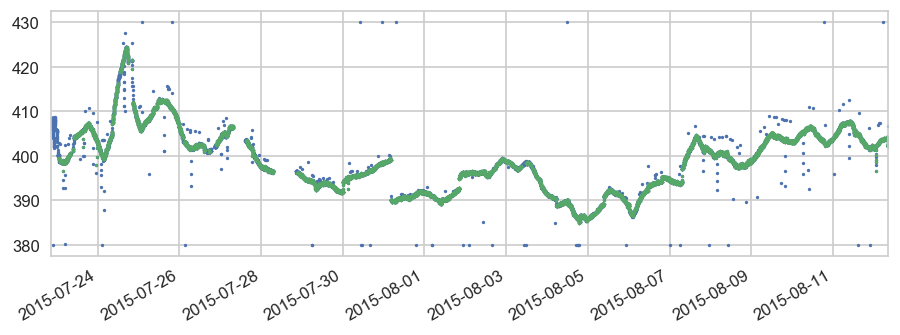

In [47]:
df2.loc[:, 'CO2f_sst'].clip(330, 430).plot(marker='.', ms=4, lw=0, figsize=[9, 3])
df3.loc[:, 'CO2f_sst'].clip(330, 430).plot(marker='.', ms=4, lw=0)
show()

df2.loc[:, 'CO2f_atm'].clip(380, 430).plot(marker='.', ms=4, lw=0, figsize=[9, 3])
df3.loc[:, 'CO2f_atm'].clip(380, 430).plot(marker='.', ms=4, lw=0)
show()

# SOCAT flags

Under construction

(0, 20)

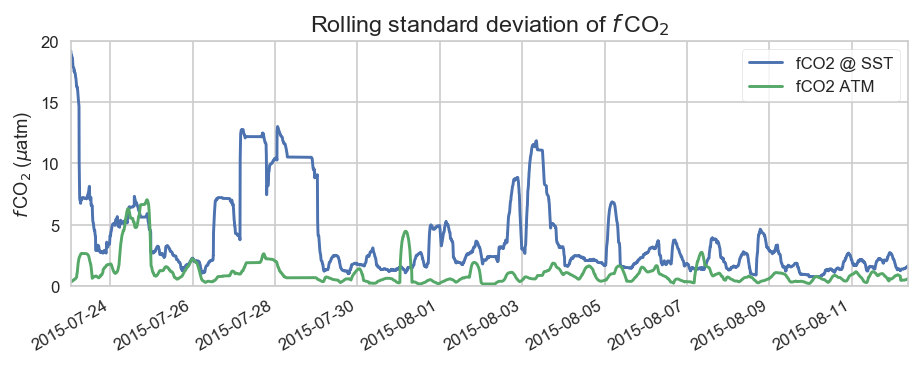

In [48]:
figure(figsize=[9, 3])
df3.CO2f_sst.rolling(window=240, center=True, min_periods=5).std().plot(label='fCO2 @ SST')
df3.CO2f_atm.rolling(window=240, center=True, min_periods=5).std().plot(label='fCO2 ATM')
title('Rolling standard deviation of $f\,$CO$_2$')
legend(frameon=1)
ylabel('$f\,$CO$_2$ ($\mu$atm)')
ylim(0, 20)